In [91]:
import json
import scipy.io
import math
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
# import glob
# glob.glob('../data/json/*4LI8GO7*')

### Import data

In [2]:
# open(filename, 'r').read(), we search for json file and .m file containing t
def get_report(session):
    report = open('../data/processed_data/try2/report.txt', 'r')
    desktop = None
    for line in report.readlines():
        if session in line:
            desktops = line.partition('desktop ')[-1]
            desktop = desktops.split(',')[:-1]
    if desktop is None:
        raise ValueError('Unable to fetch desktop information')
        
    return desktop

In [3]:
def eeg_all_timestamps():
    sessions = ["0826_1000", "0825_1300", "0830_1300", "0819_1400", 
    "0817_1000", "0831_1300", "0901_1300", "0827_1000", "0811_1000", 
    "0920_1600", "0823_1400", "1005_1600", "0828_1300", "0818_1000", 
    "0816_1400", "0930_1700", "0917_1030", "0727_1400", "0928_1600", 
    "0818_1600", "0802_1400", "0927_0930", "0915_1000", "0825_1000", 
    "0824_1600", "0826_1300", "0813_1000", "0924_1000", "0806_1000", 
    "0923_1000", "0901_1000", "0824_1000", "0831_1000", "0731_1000", 
    "0923_1600", "0922_1000", "0924_1600", "0813_1600"];

    all_timestamps = scipy.io.loadmat('../data/processed_data/all_timestamps.mat')
    all_timestamps2 = scipy.io.loadmat('../data/processed_data/all_timestamps2.mat')
    
    EEG_ALL_Timestamps = dict()
    for i in range(13):
        session = sessions[i]
        session_timestamps = dict()
        num_desktop = len(all_timestamps['all_timestamps'][0][i][1][0])
        for j in range(num_desktop):
            desktop = all_timestamps['all_timestamps'][0][i][1][0][j][0][0]
            timestamp = [float(all_timestamps['all_timestamps'][0][i][1][0][j][1][0]), 
                         float(all_timestamps['all_timestamps'][0][i][1][0][j][2][0])]
            session_timestamps[desktop] = timestamp
        EEG_ALL_Timestamps[session] = session_timestamps

    for i in range(24):
        session = sessions[14+i]
        session_timestamps = dict()
        num_desktop = len(all_timestamps2['all_timestamps'][0][i][1][0])
        for j in range(num_desktop):
            desktop = all_timestamps2['all_timestamps'][0][i][1][0][j][0][0]
            timestamp = [float(all_timestamps2['all_timestamps'][0][i][1][0][j][1][0]), 
                         float(all_timestamps2['all_timestamps'][0][i][1][0][j][2][0])]
            session_timestamps[desktop] = timestamp
        EEG_ALL_Timestamps[session] = session_timestamps
    
    return EEG_ALL_Timestamps

In [4]:
def load_data(session, desktop):
    '''
    Parameter: a string that specifies the session that we want to look at
    return: json_data and eeg_data corresponding to the session
    '''
    
    json_path = '../data/json'
    eeg_path = '../data/processed_data/try2/processed'
    json_list = os.listdir(json_path)
    eeg_list = os.listdir(eeg_path)
    json_data = eeg_data = None
    
    for file in json_list:
        if session in file and desktop in file:
            json_data = json.load(open(os.path.join(json_path, file)))
    for file in eeg_list:
        if session in file and desktop in file:
            eeg_data = scipy.io.loadmat(os.path.join(eeg_path, file))['preprocessed_EEG']
    if json_data is None:
        raise ValueError('No json file')
    if eeg_data is None:
        raise ValueError('No eeg data')
            
    return json_data, eeg_data

In [5]:
def eeg_timestamp(session, desktop, EEG_ALL_Timestamps):
    for key in EEG_ALL_Timestamps.keys():
        if key == session:
            desktops = EEG_ALL_Timestamps[session]
            for value in desktops.keys():
                if value == "DESKTOP-" + desktop:
                    EEG_start_time = desktops[value][0]
                    EEG_end_time = desktops[value][1]
    return EEG_start_time, EEG_end_time

In [6]:
def cropped_eeg(eeg_data, json_data, eeg_timestamps):
    eeg_first_timestamp, eeg_last_timestamp = eeg_timestamps
    json_start_time = json_data['details']['initial timestamp']
    json_end_time = json_data['details']['final timestamp']
    if (abs(eeg_first_timestamp - json_start_time) > 10e-2) & (eeg_first_timestamp < json_start_time):
        init_offset = abs(eeg_first_timestamp - json_start_time)
        eeg_data = eeg_data[:, init_offset*256:]
        print('Inital offset applied')
    else:
        print('No initial offset')
    if (abs(eeg_last_timestamp - json_end_time) > 10e-2) & (eeg_last_timestamp > json_end_time):
        end_offset = abs(eeg_last_timestamp - json_end_time)
        end = eeg_data.shape[1]
        cropped_eeg_data = eeg_data[:, :round(end-end_offset*256)]
        print('End offset applied')
    else:
        print('No end offset')
    return cropped_eeg_data

In [7]:
# sessions = ["0826_1000", "0825_1300", "0830_1300", "0819_1400", 
#     "0817_1000", "0831_1300", "0901_1300", "0827_1000", "0811_1000", 
#     "0920_1600", "0823_1400", "1005_1600", "0828_1300", "0818_1000", 
#     "0816_1400", "0930_1700", "0917_1030", "0727_1400", "0928_1600", 
#     "0818_1600", "0802_1400", "0927_0930", "0915_1000", "0825_1000", 
#     "0824_1600", "0826_1300", "0813_1000", "0924_1000", "0806_1000", 
#     "0923_1000", "0901_1000", "0824_1000", "0831_1000", "0731_1000", 
#     "0923_1600", "0922_1000", "0924_1600", "0813_1600"];

# all_timestamps = scipy.io.loadmat('../data/processed_data/all_timestamps.mat')
# all_timestamps2 = scipy.io.loadmat('../data/processed_data/all_timestamps2.mat')
# all_timestamps['all_timestamps'][0] # all EEG time stamps(first half), length = 13
# all_timestamps['all_timestamps'][0][0] # the first session, 0826_1000, length = 2
# all_timestamps['all_timestamps'][0][0][0] # supposed to specify session, but not
# all_timestamps['all_timestamps'][0][0][1] # length = 1, len=2 arr inside
# all_timestamps['all_timestamps'][0][0][1][0] # desktop and first/last timestamps
# all_timestamps['all_timestamps'][0][0][1][0][0] # session 1, desktop 1, first/last timestamp, length = 3
# all_timestamps['all_timestamps'][0][0][1][0][0][0] # length=1, arr inside
# all_timestamps['all_timestamps'][0][0][1][0][0][0][0] # desktop
# all_timestamps['all_timestamps'][0][0][1][0][0][1][0] # first time stamp
# all_timestamps['all_timestamps'][0][0][1][0][0][2][0] # last time stamp
# all_timestamps['all_timestamps'][0][0][1][0][1] # session 1, desktop 2, first/last timestamp, length = 3

In [8]:
# EEG_timestamps = {sessions : {desktop: [first, last]}}, length = 37, No.14 data impaired.

# EEG_ALL_Timestamps = dict()
# for i in range(13):
#     session = sessions[i]
#     session_timestamps = dict()
#     num_desktop = len(all_timestamps['all_timestamps'][0][i][1][0])
#     for j in range(num_desktop):
#         desktop = all_timestamps['all_timestamps'][0][i][1][0][j][0][0]
#         timestamp = [float(all_timestamps['all_timestamps'][0][i][1][0][j][1][0]), 
#                      float(all_timestamps['all_timestamps'][0][i][1][0][j][2][0])]
#         session_timestamps[desktop] = timestamp
#     EEG_ALL_Timestamps[session] = session_timestamps

# for i in range(24):
#     session = sessions[14+i]
#     session_timestamps = dict()
#     num_desktop = len(all_timestamps2['all_timestamps'][0][i][1][0])
#     for j in range(num_desktop):
#         desktop = all_timestamps2['all_timestamps'][0][i][1][0][j][0][0]
#         timestamp = [float(all_timestamps2['all_timestamps'][0][i][1][0][j][1][0]), 
#                      float(all_timestamps2['all_timestamps'][0][i][1][0][j][2][0])]
#         session_timestamps[desktop] = timestamp
#     EEG_ALL_Timestamps[session] = session_timestamps

### Data

In [92]:
# Extract LCT trial presented time (all submitted games)
def extract_trial_timestamps(json_data):
    presented_timestamps = [] # 2sec before trial was presented
    submission_timestamps = [] # 2sec before the next trial was presented
    gamble_number = []
    ambiguity = []
    condition = []
    num_trials = len(json_data['trials'])
    for i in range(num_trials):
        if len(json_data['trials'][i]['lct']) >= 3:
            presented_timestamps.append(json_data['trials'][i]['lct'][0]['time']-2)
            submission_timestamps.append(json_data['trials'][i]['lct'][-1]['time']+2)
            gamble_number.append(json_data['trials'][i]['lct'][0]['event']['parameters']['gamble']['gamble number'])
            ambiguity.append(json_data['trials'][i]['lct'][0]['event']['parameters']['gamble']['ambiguity'])
            condition.append(json_data['trials'][i]['lct'][0]['event']['parameters']['gamble']['condition'])
        else:
            gamble = json_data['trials'][i]['lct'][0]['event']['parameters']['gamble']['gamble number']
            trial = json_data['trials'][i]['lct'][0]['event']['parameters']['trial number']
            print('Trial', trial, 'gamble', gamble, 'not submitted at this round')
    if (submission_timestamps - presented_timestamps < 10 for i in range(132)): print('Timestamps ready')
    else: print('Error: Decision time exceeds 10 seconds.')
    
    return presented_timestamps, submission_timestamps, gamble_number, ambiguity, condition

In [93]:
presented_timestamps, submission_timestamps, gamble_number, ambiguity, condition = extract_trial_timestamps(json_0731_1000_desktop1)

Trial 1 gamble 53 not submitted at this round
Trial 2 gamble 47 not submitted at this round
Trial 3 gamble 39 not submitted at this round
Trial 4 gamble 33 not submitted at this round
Trial 54 gamble 42 not submitted at this round
Timestamps ready


In [69]:
cropped_eeg_0731_1000_desktop1.shape

(21, 260127)

In [61]:
presented_timestamps[0]

7873.9997343

In [62]:
(presented_timestamps[0] - json_start_time) * 256

61719.31284479983

In [65]:
(submission_timestamps[0] - presented_timestamps[0]) * 256

1880.1319936001673

In [70]:
cropped_eeg_0731_1000_desktop1_notimescroll = cropped_eeg_0731_1000_desktop1[:20, :]

In [71]:
cropped_eeg_0731_1000_desktop1_notimescroll.shape

(20, 260127)

In [138]:
# create df
def create_dataframe(session, desktop, cropped_eeg_data, json_data):
    json_start_time = json_data['details']['initial timestamp']
    json_end_time = json_data['details']['final timestamp']
    presented_timestamps, submission_timestamps, gamble_number, ambiguity, condition = extract_trial_timestamps(json_data)
    eeg = []
    for i in range(132):
        start_idx = math.floor((presented_timestamps[i] - json_start_time) * 256)
        end_idx = start_idx + math.ceil((submission_timestamps[i] - presented_timestamps[i]) * 256)
        trial_eeg = cropped_eeg_data[:20, start_idx:end_idx]
        eeg.append(trial_eeg)
    
    result = {'desktop': desktop * 132,
              'session' : [session] * 132,
              'gamble number': gamble_number,
              'condition' : condition,
              'ambiguity' : ambiguity,
              'eeg' : eeg}
    return pd.DataFrame(result)

In [139]:
df = create_dataframe(session, desktop, cropped_eeg_0731_1000_desktop1,json_0731_1000_desktop1)

Trial 1 gamble 53 not submitted at this round
Trial 2 gamble 47 not submitted at this round
Trial 3 gamble 39 not submitted at this round
Trial 4 gamble 33 not submitted at this round
Trial 54 gamble 42 not submitted at this round
Timestamps ready


In [140]:
df.head()

,desktop,session,gamble number,condition,ambiguity,eeg
0,U9TEJGM,0731_1000,16,computer,0,"[[-10.55143, -15.435569, -20.426535, -26.65089..."
1,U9TEJGM,0731_1000,39,computer,3,"[[10.896436, 16.619242, 17.447847, 18.896437, ..."
2,U9TEJGM,0731_1000,54,social,6,"[[-7.9544435, 2.7115383, -1.9548635, -7.331434..."
3,U9TEJGM,0731_1000,14,social,0,"[[-13.702302, -17.544489, -15.555747, -13.7489..."
4,U9TEJGM,0731_1000,13,computer,0,"[[-30.147678, -14.920945, 2.1981947, 6.7139115..."


In [73]:
# trial 1:
trial_1_eeg = cropped_eeg_0731_1000_desktop1_notimescroll[:,61719:61719+1880]

In [30]:
json_0731_1000_desktop1['trials'][0]['lct']

[{'time': 7847.44588,
  'event': {'show screen': 'gamble',
   'parameters': {'trial number': 1,
    'left is keep': True,
    'gamble': {'gamble number': 53,
     'keep amount': 13,
     'invest amount 1': 3.5,
     'invest probability 1': 0.38,
     'invest amount 2': 19.1,
     'invest probability 2': 0.62,
     'condition': 'social',
     'ambiguity': 6,
     'invest picture': 'CFD-WF-034-006-N.jpg',
     'invest image': 'GambleImages/53_INVEST__SOCIAL__NOTCLICKED',
     'keep image': 'GambleImages/53_KEEP__NOTCLICKED'}}}},
 {'time': 7850.6998408,
  'event': {'gamble clicked': {'side': 'LEFT', 'choice': 'KEEP'}}}]

In [11]:
# behavioral data: dictionary
# keys: 'station id', 'file name', 'details', 'trials'
# values: 
    # station id: desktop 
    # file name: directory on drive (no local access)
    # details: dictionary, 'id': session and desktop, 'trials played': num_trials, 'gambles presented': 
    #          num of trials presented/skipped/submitted/social&computer, 'gamle not presented', 
    #          'gambles submitted': 132(should be), 'game completed', 'initial timestamp', 'final timestamp',
    #          'stream length', 'info'
    # trials: length = 'trials played'; each is a dict, length = 4; 
    #        'gamble details': choice(side, keep/invest/probability, social/computer, ambiguity)
    #       *'lct': when presented, when clicked, when submitted, trial details
    #        'eye': eye tracking data, ignore for now
    #        'transform': 'helmet', 'controller' (unknow, VR transform??)

In [12]:
# EEG data: dictionary
# header, version, globle, *(eeg_data)prerpocessed_EEG (np.ndarray, length = 21)
# len(eeg_0731_1000_desktop1['preprocessed_EEG'][0]) = num_timestamp, sample rate = 256

In [27]:
EEG_ALL_Timestamps = eeg_all_timestamps()
EEG_ALL_Timestamps

In [14]:
session = '0731_1000'
desktop = get_report(session)

In [15]:
json_0731_1000_desktop1, eeg_0731_1000_desktop1 = load_data(session, desktop[0])

In [16]:
json_start_time = json_0731_1000_desktop1['details']['initial timestamp']
json_end_time = json_0731_1000_desktop1['details']['final timestamp']
json_start_time, json_end_time

(7632.9086685, 8651.942109)

In [17]:
eeg_timestamps = eeg_timestamp(session, desktop, EEG_ALL_Timestamps)
eeg_first, eeg_last = eeg_timestamps

In [68]:
cropped_eeg_0731_1000_desktop1 = cropped_eeg(eeg_0731_1000_desktop1, json_0731_1000_desktop1, eeg_timestamps)

No initial offset
End offset applied


###### 0915_1000 Team22 session1

In [187]:
session = '0915_1000'
desktop = get_report(session)
desktop

['539136F', 'U9TEJGM', '9M4VCHG']

In [188]:
json_0915_1000_desktop2, eeg_0915_1000_desktop2 = load_data(session, desktop[1])

In [190]:
json_0915_1000_desktop2['details']['initial timestamp'], json_0915_1000_desktop2['details']['final timestamp']

(1385502.5515451, 1386775.3710733)

In [192]:
json_0915_1000_desktop2['trials'][0]['lct']

[{'time': 1385824.4081678,
  'event': {'show screen': 'gamble',
   'parameters': {'trial number': 1,
    'left is keep': True,
    'gamble': {'gamble number': 36,
     'keep amount': 7,
     'invest amount 1': 2.1,
     'invest probability 1': 0.31,
     'invest amount 2': 10.4,
     'invest probability 2': 0.69,
     'condition': 'social',
     'ambiguity': 3,
     'invest picture': 'CFD-WM-209-038-N.jpg',
     'invest image': 'GambleImages/36_INVEST__SOCIAL__NOTCLICKED',
     'keep image': 'GambleImages/36_KEEP__NOTCLICKED'}}}},
 {'time': 1385828.9166417,
  'event': {'gamble clicked': {'side': 'RIGHT', 'choice': 'INVEST'}}}]

In [193]:
json_0915_1000_desktop2['trials'][-1]['lct']

[{'time': 1386755.8128436,
  'event': {'show screen': 'gamble',
   'parameters': {'trial number': 148,
    'left is keep': True,
    'gamble': {'gamble number': 12,
     'keep amount': 5,
     'invest amount 1': 1.1,
     'invest probability 1': 0.24,
     'invest amount 2': 7.3,
     'invest probability 2': 0.76,
     'condition': 'computer',
     'ambiguity': 0,
     'invest picture': '5_roulette.png',
     'invest image': 'GambleImages/12_INVEST__COMPUTER__NOTCLICKED',
     'keep image': 'GambleImages/12_KEEP__NOTCLICKED'}}}},
 {'time': 1386757.4785748,
  'event': {'gamble clicked': {'side': 'RIGHT', 'choice': 'INVEST'}}},
 {'time': 1386759.0667345,
  'event': {'submit': {'selected high payout': '7.3',
    'selected high probability': '0.76',
    'selected low payout': '1.1',
    'selected low probability': '0.24',
    'nonselected high payout': '5',
    'nonselected high probability': '1.0',
    'nonselected low payout': 'NA',
    'nonselected low probability': 'NA',
    'ambiguity

### json data structure explanation ["details"]
dictionary;

key: details;

values: desktop id, trials, info

WE NEED: "stream length", which is the length of the entire session of the experiement, the one that we should use to align with the eegdata.

*CAVEAT: There are repeated trials presensted to the subject because the first round was ignored or unchosen. Therefore even though "trial played" could be a larger number, "gamble presented" and "gambles submitted" should be 132. For example, if the subject skipped on trial 24, he will be presented the same wheel again in 129, therefore in that single line of content in "gamble details", there are two trials stored but only the LAST one in the list is the one that the subject submitted. Still we need to take a look at the "gamble not presented" and make sure it is zero.

In [82]:
# details of each gamble trial / behavioral data
json_0924_1600_desktop2['details']

{'id': '0924_1600_LCT_DESKTOP-U9TEJGM',
 'trials played': 132,
 'gambles presented': {'1_computer': {'trials shown on': [25],
   'trials skipped on': [],
   'trial chosen on': 25,
   'repeats': 0},
  '1_social': {'trials shown on': [35],
   'trials skipped on': [],
   'trial chosen on': 35,
   'repeats': 0},
  '2_computer': {'trials shown on': [96],
   'trials skipped on': [],
   'trial chosen on': 96,
   'repeats': 0},
  '2_social': {'trials shown on': [95],
   'trials skipped on': [],
   'trial chosen on': 95,
   'repeats': 0},
  '3_computer': {'trials shown on': [13],
   'trials skipped on': [],
   'trial chosen on': 13,
   'repeats': 0},
  '3_social': {'trials shown on': [51],
   'trials skipped on': [],
   'trial chosen on': 51,
   'repeats': 0},
  '4_computer': {'trials shown on': [71],
   'trials skipped on': [],
   'trial chosen on': 71,
   'repeats': 0},
  '4_social': {'trials shown on': [19],
   'trials skipped on': [],
   'trial chosen on': 19,
   'repeats': 0},
  '5_compute

In [83]:
details = json_0924_1600_desktop2['details']
len(details['gambles presented'])

132

In [84]:
details['gambles submitted']

132

In [85]:
details.keys()

dict_keys(['id', 'trials played', 'gambles presented', 'gambles not presented', 'gambles submitted', 'game completed', 'reward', 'initial timestamp', 'final timestamp', 'stream length', 'info'])

In [86]:
# behavioral data time duration
json_0924_1600_desktop2['details']['stream length'] # software time recorded
json_0924_1600_desktop2['details']['stream length'] / 60 # in minutes

12.155141065000013

### Json data struture explanation ["trials"]
dictionary:

each value contains the information of each trial, corresponding to the total number of "trial played".

each trial contains 'gamble details', 'lct', 'eye', 'transforms', and 'lct' and 'gamble details" contain similar if not same info. 'eye' contains pupil data, which is not the primary concern here. 'helmet'?

We would like to use the 'lct' and 'gamble details' for behavioral data and 'time' inside to epoch the eeg data for alignment.

In [167]:
json_0924_1600_desktop2['trials'][0]['transforms'].keys()

dict_keys(['helmet', 'controller'])

In [88]:
trial_1 = json_0924_1600_desktop2['trials'][0]
trial_last = json_0924_1600_desktop2['trials'][-1]

In [89]:
trial_1 = json_0924_1600_desktop2['trials'][0]
trial_1['lct']

[{'time': 115724.2678129,
  'event': {'show screen': 'gamble',
   'parameters': {'trial number': 1,
    'left is keep': False,
    'gamble': {'gamble number': 59,
     'keep amount': 8,
     'invest amount 1': 2.2,
     'invest probability 1': 0.32,
     'invest amount 2': 11.8,
     'invest probability 2': 0.68,
     'condition': 'social',
     'ambiguity': 6,
     'invest picture': 'CFD-BF-250-121-N.jpg',
     'invest image': 'GambleImages/59_INVEST__SOCIAL__NOTCLICKED',
     'keep image': 'GambleImages/59_KEEP__NOTCLICKED'}}}},
 {'time': 115725.9114158,
  'event': {'gamble clicked': {'side': 'LEFT', 'choice': 'INVEST'}}},
 {'time': 115727.0345214,
  'event': {'submit': {'selected high payout': '11.8',
    'selected high probability': '0.68',
    'selected low payout': '2.2',
    'selected low probability': '0.32',
    'nonselected high payout': '8',
    'nonselected high probability': '1.0',
    'nonselected low payout': 'NA',
    'nonselected low probability': 'NA',
    'ambiguity'

In [90]:
time = []
init_time = []
submit_time = []
diff = []
sub_init_diff = []
gap = []
for i in range(len(json_0924_1600_desktop2['trials'])):
    trial = json_0924_1600_desktop2['trials'][i]
    init_time.append(trial['lct'][0]['time'])
    submit_time.append(trial['lct'][2]['time'])
    sub_init_diff.append(trial['lct'][2]['time'] - trial['lct'][0]['time'])
    diff.append(init_time[i]-init_time[i-1])
    gap.append(init_time[i]-submit_time[i-1])

In [92]:
np.sum(np.array(gap)>4)

9

In [63]:
sub_init_diff

[2.7667084999993676,
 3.5982286000071326,
 1.5325669000012567,
 2.0544659000006504,
 2.054437400001916,
 1.754724599988549,
 2.1543855000054464,
 1.9303096999938134,
 1.6984835000039311,
 3.087314199990942,
 1.6768754000077024,
 1.3760814999986906,
 1.576885400005267,
 1.3436171999928774,
 2.043459900000016,
 1.1324320999992779,
 1.9765803000045707,
 2.2878191000054358,
 1.9775674999982584,
 1.421214300004067,
 1.7213308999926085,
 2.5207580999995116,
 1.7863148000033107,
 2.720857199994498,
 1.509438000008231,
 1.8877560999972047,
 2.376377099993988,
 1.5213190000067698,
 1.53156120001222,
 2.0099188999884063,
 1.377206200006185,
 1.7656485999905271,
 1.9657149000122445,
 1.743456399999559,
 2.2765404999954626,
 1.8864210000028834,
 2.043151999998372,
 1.2104548000061186,
 1.5435631000000285,
 2.1211968999996316,
 1.9101455000054557,
 2.3536138999916147,
 2.3543576000083704,
 1.4880133000115165,
 2.9872559999930672,
 1.57617489999393,
 2.576542500013602,
 1.5991229000064777,
 2.665338

In [57]:
diff.index(max(diff)), diff

(90,
 [0.0,
  7.207842499992694,
  4.686813100008294,
  5.164275300005102,
  5.1754464999976335,
  4.9200146999937715,
  5.009054599999217,
  5.175253100009286,
  5.008830699996906,
  5.1089221000002,
  5.564106299993,
  5.486484699998982,
  4.753374899999471,
  4.46468289999757,
  4.897790900009568,
  4.4646853000012925,
  5.186709000001429,
  5.186390999995638,
  5.231001499996637,
  4.631252499995753,
  4.786920900005498,
  5.186338900006376,
  5.275515599991195,
  5.186493200002587,
  5.308715799998026,
  5.053345300009823,
  4.8643991999997525,
  5.331132799998159,
  4.764476799988188,
  4.953293400001712,
  5.4864927000016905,
  4.897795099997893,
  4.697793200000888,
  5.2532101000106195,
  6.26384839999082,
  4.975556899997173,
  5.308699500004877,
  4.375809799996205,
  4.65360450001026,
  4.686666099994909,
  5.375481299997773,
  5.030951000007917,
  6.041842299993732,
  4.742461999994703,
  4.76431009999942,
  6.008467700012261,
  5.208887199987657,
  5.219851700006984,
  5.

In [33]:
trial_1['transforms']['helmet']

[{'local to world transform': [0.9995129,
   -0.01894908,
   0.02479873,
   -0.032678,
   0.0112192,
   0.9596214,
   0.2810711,
   1.040433,
   -0.02912343,
   -0.280656,
   0.9593665,
   -950.6322,
   0,
   0,
   0,
   1],
  'world to local transform': [0.9995129,
   0.0112192,
   -0.02912343,
   -27.66468,
   -0.01894908,
   0.9596214,
   -0.280656,
   -267.7996,
   0.02479873,
   0.2810711,
   0.9593665,
   911.7131,
   0,
   0,
   0,
   1],
  'origin': [-0.032678, 1.040433, -950.6322],
  'direction': [0.02479873, 0.2810711, 0.9593665],
  'euler angles': [343.6758, 1.480713, 0.6698302],
  'time': 115724.279302},
 {'local to world transform': [0.9994284,
   -0.01920537,
   0.02782166,
   -0.03236947,
   0.01062468,
   0.9597023,
   0.280818,
   1.040444,
   -0.03209372,
   -0.2803619,
   0.9593577,
   -950.6322,
   0,
   0,
   0,
   1],
  'world to local transform': [0.9994284,
   0.01062468,
   -0.03209372,
   -30.48803,
   -0.01920537,
   0.9597023,
   -0.2803619,
   -267.5202,
  

In [34]:
len(trial_1['eye'])

332

In [35]:
trial_1['eye'][0]['time']

115724.26859968145

In [36]:
trial_1['eye'][-1]['time']

115727.02681100748

In [93]:
eeg_0924_1600_desktop2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'preprocessed_EEG'])

In [94]:
eeg_0924_1600_desktop2['__header__'], eeg_0924_1600_desktop2['__version__'], eeg_0924_1600_desktop2['__globals__']

(b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Apr 26 14:10:50 2023',
 '1.0',
 [])

In [95]:
eeg_0924_1600_desktop2['preprocessed_EEG'].shape

(21, 252432)

In [96]:
# removed channel
len(eeg_0924_1600_desktop2['preprocessed_EEG'])

21

In [97]:
# time
# mat['preprocessed_EEG'][-1][:100]
len(eeg_0924_1600_desktop2['preprocessed_EEG'][-1])

252432

In [98]:
252432 / 256 / 60

16.434375

 ...]

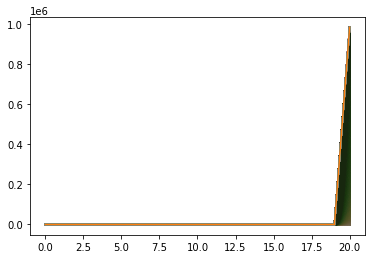

In [99]:
plt.plot(eeg_0924_1600_desktop2['preprocessed_EEG'])

### 1005_1600 Team26 session 3

In [4]:
session = '1005_1600'
desktop = get_report(session)
json_1005_1600_desktop1, eeg_1005_1600_desktop1 = load_data(session, desktop[0])

In [33]:
json_1005_1600_desktop1['details']['initial timestamp'], json_1005_1600_desktop1['details']['final timestamp']

(2668.2394237, 3412.6842297)

In [34]:
json_1005_1600_desktop1['details']['final timestamp'] - json_1005_1600_desktop1['details']['initial timestamp']

744.444806

In [35]:
744.444806 / 60
# extract timestap and plot

12.407413433333334

In [5]:
len(eeg_1005_1600_desktop1['preprocessed_EEG'][-1])

218519

In [37]:
218519 / 256 / 60

14.226497395833333

In [1]:
# plot time scroll
# google doc paper reference list
# check the preprocessed eegdata (nicely preprocessed eggdata example)
# data alignment eeg vs json: start time should be the same (disconnection sometimes) -> 
# using calibration test (flashing white cross on background) to calibrate the eegdata

In [8]:
eeg_1005_1600_desktop1['preprocessed_EEG'].shape

(21, 218519)